# Create telluric absorption atlases relevant to DKIST for calibration purposes

Tom Schad | 7 March 2024

* US Standard Atmosphere 


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import glob
import sys
import py4cats 
print(py4cats.__file__)

import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'gray'
plt.rcParams["image.interpolation"] = 'nearest'
plt.rcParams['font.sans-serif'] = "Comic Sans MS"
plt.rcParams['font.family'] = "serif"
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from scipy import ndimage

from tqdm.auto import trange
import multiprocessing
from IPython.display import clear_output


Py4CAtS --- Python for Computational ATmospheric Spectroscopy

A collection of Python scripts for (molecular) line-by-line absorption
(cross sections, optical depths, ...) and atmospheric radiative transfer

https://doi.org/10.3390/atmos10050262    --->   Atmosphere 10(5), 262, 2019
https://atmos.eoc.dlr.de/tools/Py4CAtS/

/home/tschad/dkist_telluric_atlas/py4cats/__init__.py


In [2]:
hitran_data_file = './HITRAN_VIS_IR/65e912c9.par'
os.makedirs('./telluric_synAtlas/',exist_ok=True)

In [3]:
def vac2air(wave_vac):
    """ 
    Converts wavelengths from vacuum to air-equivalent 
    Morton (2000, ApJ. Suppl., 130, 3043); IAU standard

    wave_vac is given in Angstroms
    
    """
    wave_vac = np.atleast_1d(wave_vac)
    wave_air = np.copy(wave_vac)
    ww  = (wave_vac >= 2000) 
    sigma2 = (1e4 / wave_vac[ww])**2 
    n = 1 + 0.0000834254 + 0.02406147 / (130 - sigma2) + 0.00015998 / (38.9 - sigma2)
    wave_air[ww] = wave_vac[ww] / n
    return wave_air

In [4]:
def air2vac(wave_air): 
    """ Converts wavelengths from air-equivalent to vacuum
    Ciddor (1996) formula
    Adapted from airtovac.pro
    wave_air  :: angstroms 
    
    https://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion
    
    """
    wave_air = np.atleast_1d(wave_air)
    wave_vac = np.copy(wave_air)
    ww  = (wave_air >= 2000) 
    sigma2 = (1e4 / wave_air[ww])**2 
    n = 1. + 8.336624212083e-5 + 0.02408926869968 / (130.1065924522 - sigma2) + \
        0.0001599740894897 / (38.92568793293 - sigma2)
    wave_vac[ww] = wave_air[ww] * n
    return wave_vac
    

In [5]:
## Wavenumber range of 350 to 5000 nm  (3500 to 50000 Angstrom)
wnMax,wnMin = 1e7/(air2vac(np.array([3500.,50000.]))/10.)
## 2546 to 2536

## Load Terrestrial atmospheric profile 

* Here we will using the US standard atmosphere but scale the CO2 concentrations for recent global averages

In [6]:
print('=========================================')
print(' ')
print(' Loading US Standard Atmosphere')
atm_standard = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy') ## Using standard atmosphere
cmr_co2_std = py4cats.cmr(atm_standard,'CO2',zMin = .0)
print(' ---> CO2 Mixing Correction...')
print(f"   Column Mixing Ratio of CO2 in US standard atmosphere: {cmr_co2_std}") 
cmr_co2_set = 0.000416   ## global average CO2 for Dec 2023 -  416 ppm 
CO2_ratio = cmr_co2_set / cmr_co2_std
print(f"   Set point for CO2 mixing ratio: {cmr_co2_set}")
print(f"   Ratio to apply: {CO2_ratio:.3f}")
rho = 0.9998  # mass density of water in (g/cm**3)
M  = 18.01528 # average molar mass of water in  (g / mole )
Na = 6.022e23 # Avagadro's number (molec / mole)
PWV = py4cats.vcd(atm_standard,'H2O',zMin = 0.0)/rho/Na * M * 10  ## millimeters
print(f" Precipitable Water: {PWV:.2f} millimeters")

print(' ')
print('=========================================')
print(' Setting Base of Atmosphere to be at the height of DKIST') 
atm_standard = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy',zBoA  = 3e5) #### Base of Atmospher --> 3 KILOMETERS FOR HALEAKALA - DKIST 
atm_standard['CO2'] = atm_standard['CO2'] * CO2_ratio  ## scaling of CO2 
PWV = py4cats.vcd(atm_standard,'H2O',zMin = 0.0)/rho/Na * M * 10  ## millimeters
print(f" PWV {PWV:.2f} millimeters")
## Set selected atmosphere to atmDat for use below
atmDat = atm_standard

 
 Loading US Standard Atmosphere
 Atmos1d: got p, T, air   and 7 molecules on 50 levels
 ---> CO2 Mixing Correction...
   Column Mixing Ratio of CO2 in US standard atmosphere: 0.0003299997842732906
   Set point for CO2 mixing ratio: 0.000416
   Ratio to apply: 1.261
 Precipitable Water: 14.39 millimeters
 
 Setting Base of Atmosphere to be at the height of DKIST
 Atmos1d: got p, T, air   and 7 molecules on 50 levels
 PWV 3.43 millimeters


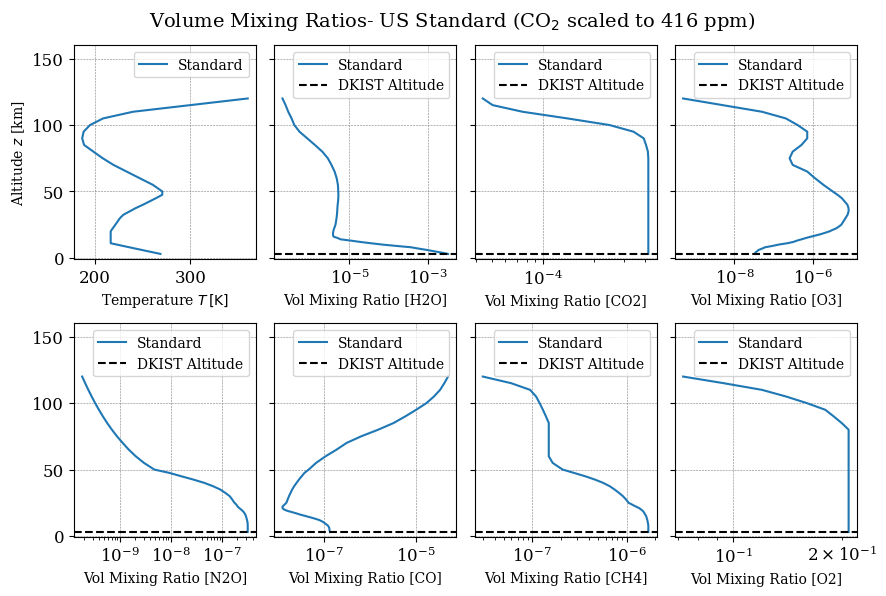

In [7]:
fig,ax = plt.subplots(2,4,figsize = (9,6),sharey=True)
ax = ax.flatten()
plt.sca(ax[0])
py4cats.atmPlot(atmDat,label = 'Standard')
ax[0].legend(fontsize=10)

main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
for n in range(1,8): 
    plt.sca(ax[n])
    plt.plot(py4cats.vmr(atmDat,main_mol[n-1]),atm_standard['z']/1e5,label = 'Standard')
    plt.xscale('log')
    plt.xlabel('Vol Mixing Ratio ['+main_mol[n-1] + ']')
    ax[n].axhline(3.,ls = 'dashed',color = 'black',label = 'DKIST Altitude')
    ax[n].legend(loc = 'upper right',fontsize=10)
    
ax[0].set_ylim(-1,160)
for axi in ax:  axi.grid(ls = 'dashed',lw = 0.4,color = 'grey')   
fig.suptitle(r"Volume Mixing Ratios- US Standard (CO$_{2}$ scaled to 416 ppm)",fontsize = 14) 
fig.subplots_adjust(0.08,0.1,0.95,0.92,wspace=0.1,hspace = 0.3)

## Example calculation over a smaller wavelength range of the data 

--> this is a development step to be able to split the computation over multiple processes

In [8]:
## Wavelength bounds in Angstrom 
wv0,wv1 = 10825,10845   

## pad by some factor for edge treatment 
## this is to prevent artifacts from absorption features outside of the desired range. 
padWidth = 2. 
wv0_padded,wv1_padded = wv0 - padWidth,wv1 + padWidth

## Wavenumber bounds in inv cm.
wn1,wn0 = 1e7/(air2vac(np.array([wv0,wv1]))/10.) 

## Get line list
dictOfLineLists = py4cats.higstract(hitran_data_file,(wn0,wn1),molecule = 'main',verbose = False)

## Read reference atmosphere again - this is because the subprocesses will need this separately 
atmDat = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy',zBoA  = 3e5) #### Base of Atmospher --> 3 KILOMETERS FOR HALEAKALA - DKIST 
atmDat['CO2'] = atmDat['CO2'] * CO2_ratio  ## scaling of CO2 
pwv_reference = py4cats.vcd(atmDat,'H2O',zMin = 0.0)/rho/Na * M * 10  ## millimeters
print(f" pwv_reference {PWV:.2f} millimeters")  ## reference measurement of the precipitable water used for scaling 

## get absorption cross sections
## Only do this once! 
xssDict = py4cats.lbl2xs(dictOfLineLists, atmDat['p'], atmDat['T'],(wn0,wn1),verbose = False)
clear_output()      ### py4cats produces a lot of outputs...can clear it here. 
print(' DONE --> Outputs cleared')

## Get absorption coefficient for the standard atmosphere
## absorption coefficients
absCoList = py4cats.xs2ac(atmDat, xssDict) 

## Delta optical depths
dodList = py4cats.ac2dod(absCoList,verbose=False)

## calculate the total optical depth 
tod = py4cats.dod2tod(dodList)  

clear_output()      ### py4cats produces a lot of outputs...can clear it here. 
print(' DONE --> Outputs cleared')

wvair = vac2air(1e7/tod.grid()*10)
where_unpadded = (wvair >= wv0) * (wvair <= wv1) 

print('Original number of wavelengths: ',len(wvair))
nwv = len(wvair[where_unpadded])
print('After unpadding: ',nwv)

## List of PPWV and AIRMASSES TO COMPUTE 
ppwv_list    = (1,2,3,4,5,6,8,10,)
airmass_list = (1,1.5,2,3,) 
n_ppwv    = len(ppwv_list)
n_airmass = len(airmass_list)

output_wv  = wvair[where_unpadded]
output_trans = np.zeros((n_ppwv,n_airmass,nwv))
print(output_trans.shape,output_wv.shape)

## loop over ppwv and airmass 
for pIndx in range(n_ppwv): 
           
    ## changes in precipitable water 
    atmDat = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy',zBoA  = 3e5)
    atmDat['CO2'] *= CO2_ratio  ## scaling of CO2 
    atmDat['H2O'] *= ppwv_list[pIndx] / pwv_reference
    
    ## absorption coefficients
    absCoList = py4cats.xs2ac(atmDat, xssDict) 
    
    ## Delta optical depths
    dodList = py4cats.ac2dod(absCoList,verbose=False)

    clear_output()      ### py4cats produces a lot of outputs...can clear it here. 
    print(' DONE --> Outputs cleared')
    
    ## Calculate total optical deths for multiple airmass conditions 
    for aIndx in range(n_airmass): 
        
        airmass = airmass_list[aIndx]
    
        ## change the airmass for a slant geometry 
        for n in range(len(dodList)): 
            dodList[n] = dodList[n]*airmass  

        ## calculate the total optical depth 
        tod = py4cats.dod2tod(dodList)  
        
        ## back-correct the list for the airmass correction
        for n in range(len(dodList)): 
            dodList[n] = dodList[n]/airmass  

        output_trans[pIndx,aIndx,:] = np.exp(-tod)[where_unpadded]

 DONE --> Outputs cleared


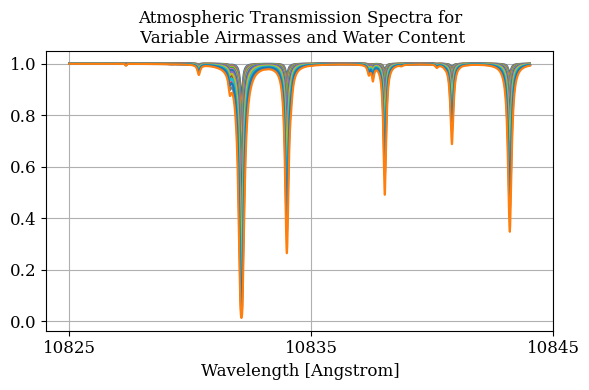

In [9]:
## Plot all calculated spectra for different airmass and ppwv
plt.figure(figsize= (6,4))
for pIndx in range(n_ppwv): 
    for aIndx in range(n_airmass): 
        plt.plot(output_wv,output_trans[pIndx,aIndx,:])
plt.xticks([wv0,(wv0+wv1)/2.,wv1])
plt.xlabel("Wavelength [Angstrom]",fontsize = 12)
plt.title('Atmospheric Transmission Spectra for\n Variable Airmasses and Water Content')
plt.grid()
plt.tight_layout()

## Create a function to be called in parallel with wavelength bounds as the arguments 

In [10]:
from IPython.utils import io

def genTelluricAtlas(argin): 
    '''argin is the wavelength bounds in Angstrom 
    
    outputs - wavelength vectors and array of spectral for the airmasses and ppwv defined 
    '''

    wv0,wv1 = argin 

    ## THIS IS SO THE OUTPUT DOESNT OVERWHELMN THE NOTEBOOK IN PARALLEL CASE 
    with io.capture_output() as captured: 

        ## pad by some factor for edge treatment 
        ## this is to prevent artifacts from absorption features outside of the desired range. 
        padWidth = 2. 
        wv0_padded,wv1_padded = wv0 - padWidth,wv1 + padWidth
    
        ## Wavenumber bounds in inv cm.
        wn1,wn0 = 1e7/(air2vac(np.array([wv0,wv1]))/10.) 
        
        ## Get line list
        dictOfLineLists = py4cats.higstract(hitran_data_file,(wn0,wn1),molecule = 'main',verbose = False)
        
        ## Read reference atmosphere again - this is because the subprocesses will need this separately 
        atmDat = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy',zBoA  = 3e5) #### Base of Atmospher --> 3 KILOMETERS FOR HALEAKALA - DKIST 
        atmDat['CO2'] = atmDat['CO2'] * CO2_ratio  ## scaling of CO2 
        pwv_reference = py4cats.vcd(atmDat,'H2O',zMin = 0.0)/rho/Na * M * 10  ## millimeters
        print(f" pwv_reference {PWV:.2f} millimeters")  ## reference measurement of the precipitable water used for scaling 
        
        ## get absorption cross sections
        ## Only do this once! 
        xssDict = py4cats.lbl2xs(dictOfLineLists, atmDat['p'], atmDat['T'],(wn0,wn1),verbose = False)
        clear_output()      ### py4cats produces a lot of outputs...can clear it here. 
        print(' DONE --> Outputs cleared')
        
        ## Get absorption coefficient for the standard atmosphere
        ## absorption coefficients
        absCoList = py4cats.xs2ac(atmDat, xssDict) 
        
        ## Delta optical depths
        dodList = py4cats.ac2dod(absCoList,verbose=False)
        
        ## calculate the total optical depth 
        tod = py4cats.dod2tod(dodList)  
        
        clear_output()      ### py4cats produces a lot of outputs...can clear it here. 
        print(' DONE --> Outputs cleared')
        
        wvair = vac2air(1e7/tod.grid()*10)
        where_unpadded = (wvair >= wv0) * (wvair <= wv1) 
        
        print('Original number of wavelengths: ',len(wvair))
        nwv = len(wvair[where_unpadded])
        print('After unpadding: ',nwv)
        
        ## List of PPWV and AIRMASSES TO COMPUTE 
        ppwv_list    = (1,2,3,4,5,6,8,10,)
        airmass_list = (1,1.5,2,3,) 
        n_ppwv    = len(ppwv_list)
        n_airmass = len(airmass_list)
        
        output_wv  = wvair[where_unpadded]
        output_trans = np.zeros((n_ppwv,n_airmass,nwv))
        print(output_trans.shape,output_wv.shape)
        
        ## loop over ppwv and airmass 
        for pIndx in range(n_ppwv): 
                   
            ## changes in precipitable water 
            atmDat = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy',zBoA  = 3e5)
            atmDat['CO2'] *= CO2_ratio  ## scaling of CO2 
            atmDat['H2O'] *= ppwv_list[pIndx] / pwv_reference
            
            ## absorption coefficients
            absCoList = py4cats.xs2ac(atmDat, xssDict) 
            
            ## Delta optical depths
            dodList = py4cats.ac2dod(absCoList,verbose=False)
        
            clear_output()      ### py4cats produces a lot of outputs...can clear it here. 
            print(' DONE --> Outputs cleared')
            
            ## Calculate total optical deths for multiple airmass conditions 
            for aIndx in range(n_airmass): 
                
                airmass = airmass_list[aIndx]
            
                ## change the airmass for a slant geometry 
                for n in range(len(dodList)): 
                    dodList[n] = dodList[n]*airmass  
        
                ## calculate the total optical depth 
                tod = py4cats.dod2tod(dodList)  
                
                ## back-correct the list for the airmass correction
                for n in range(len(dodList)): 
                    dodList[n] = dodList[n]/airmass  
        
                output_trans[pIndx,aIndx,:] = np.exp(-tod)[where_unpadded]

    return output_wv,output_trans

In [11]:
%%time 
## Test call the above function  
output_wv,output_trans = genTelluricAtlas((10825,10845))

CPU times: user 15.6 s, sys: 36 ms, total: 15.6 s
Wall time: 15.6 s


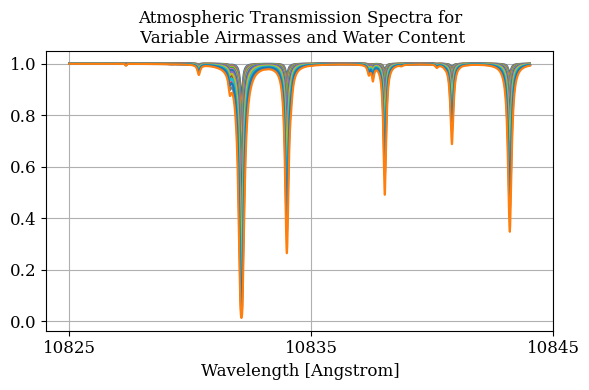

In [12]:
## Plot all calculated spectra for different airmass and ppwv
plt.figure(figsize= (6,4))
for pIndx in range(n_ppwv): 
    for aIndx in range(n_airmass): 
        plt.plot(output_wv,output_trans[pIndx,aIndx,:])
plt.xticks([wv0,(wv0+wv1)/2.,wv1])
plt.xlabel("Wavelength [Angstrom]",fontsize = 12)
plt.title('Atmospheric Transmission Spectra for\n Variable Airmasses and Water Content')
plt.grid()
plt.tight_layout()

## Parallelize the above process to compute the full 350 to 5000 nm range 

In [13]:
## split up range into 30 nm widths 
wvBnds = np.linspace(350,5000,int(np.ceil((5000-350)/30.)))
wvBnds *= 10.  ## convert to angstrom 
wv0s = wvBnds[:(-1)]
wv1s = wvBnds[1:]
print(len(wv0s))
for n in range(3):
    print(wv0s[n],wv1s[n])

arg_array = []
for n in range(len(wv0s)): 
    arg_array.append((wv0s[n],wv1s[n]))

154
3500.0 3801.948051948052
3801.948051948052 4103.896103896103
4103.896103896103 4405.8441558441555


In [14]:
## REQUIRES ABOUT 17 MINUTES ON 76 PROCESSES 
if 1: 
    ncpus = int(np.floor(0.95*multiprocessing.cpu_count()))
    ncpus = np.clip(ncpus,1,200).astype(int)
    print(f" Using {ncpus} Processes in Pool")
    p     = multiprocessing.Pool(processes=ncpus,maxtasksperchild = 1000)
    rs    = p.imap(genTelluricAtlas,arg_array)
    p.close()
    
    from tqdm import tqdm
    nargs = len(arg_array)
    pbar = tqdm(total=nargs,position = 0, leave = True)
    
    all_output_wv =[]
    all_output_trans = []
    for i,res in enumerate(rs):
        output_wv,output_trans = res 
        all_output_wv.append(output_wv)
        all_output_trans.append(output_trans)
        pbar.update()
    pbar.close()

 Using 76 Processes in Pool


  0%|                                                                                                                                                              | 0/154 [16:48<?, ?it/s]


## Create the final data arrays by interpolating to high resolution 

In [15]:
all_wvs = np.hstack(all_output_wv)
all_trans = np.concatenate(all_output_trans,axis=2)

In [16]:
all_trans.shape

(8, 4, 17521537)

In [17]:
## Create a 1 million resolution wavelength vector
wv = []
wv.append(3500.)
while wv[-1] < 50000: 
    wv.append( wv[-1] + wv[-1]/1000000)

wvair_Interp = np.array(wv,dtype = np.float64)
trans_Interp = np.zeros((8,4,len(wv)))                  

In [18]:
ppwv_list    = (1,2,3,4,5,6,8,10,)
airmass_list = (1,1.5,2,3,) 
n_ppwv    = len(ppwv_list)
n_airmass = len(airmass_list)
## loop over ppwv and airmass 
wv_sort = np.argsort(all_wvs)

for pIndx in trange(n_ppwv): 
    for aIndx in range(n_airmass): 
        trans_Interp[pIndx,aIndx,:] = np.interp(wvair_Interp,all_wvs[wv_sort],all_trans[pIndx,aIndx,:][wv_sort])

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
## CONVERT TO 32 BIT TO SAVE ON STORAGE SIZE
print(wvair_Interp.nbytes/1024./1024.,trans_Interp.nbytes/1024./1024.,'  MegaBytes')
wvair_Interp = wvair_Interp.astype(np.float32)
trans_Interp = trans_Interp.astype(np.float32)
print(wvair_Interp.nbytes/1024./1024.,trans_Interp.nbytes/1024./1024.,'  MegaBytes')

20.28856658935547 649.234130859375   MegaBytes
10.144283294677734 324.6170654296875   MegaBytes


In [20]:
## temporary save 
#np.save('wvair_Interp.npy',wvair_Interp)
#np.save('trans_Interp.npy',trans_Interp)

In [21]:
os.makedirs('./atlases/',exist_ok = True)

In [22]:
from datetime import date
today = date.today()
dateTag = str(today).replace('-','')

In [23]:
savname = './atlases/telluric_atlas_mainMol_USstd_wv_air_angstrom'+'_v' + dateTag + '.npy'  ## Save as np.float64
np.save(savname,wvair_Interp)

In [25]:
for pIndx in trange(n_ppwv): 
    for aIndx in range(n_airmass): 
        savname = './atlases/telluric_atlas_mainMol_USstd_CO2_416ppm-Base_3km-PWV_' + \
        str(ppwv_list[pIndx]).ljust(2,'_') + '_mm-Airmass_' + str(airmass_list[aIndx]).ljust(3,'_')+'_v' + dateTag + '.npy'
        np.save(savname,trans_Interp[pIndx,aIndx,:].astype(np.float32))

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0.5, 0, 'Wavelength [Angstrom]')

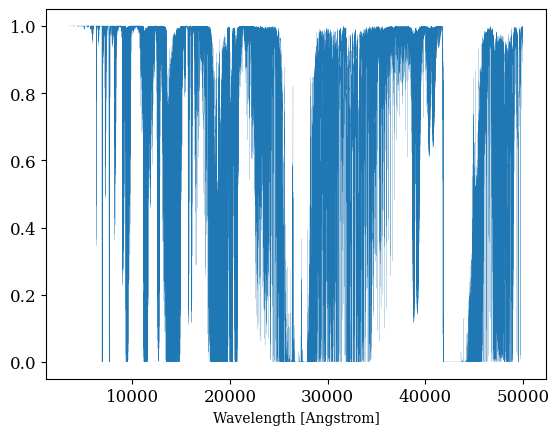

In [26]:
## Example plot 
plt.figure()
plt.plot(wvair_Interp,trans_Interp[0,0,:],lw = 0.1)
plt.xlabel("Wavelength [Angstrom]")